## Fitting routines

We are operating on the same dataset as the first, so let's just load the data and format it just like we did in the other notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import telassar

In [13]:
home = os.path.expanduser("~")
working = os.path.join(home, "telassar")
os.chdir(working)
from telassar import PVSlice
from telassar.fitter import get_noise1D

In [44]:
file = os.path.join(working, "data/hd163296_pvslice.fits")
pvdiag = PVSlice(file)

# the OI6300 window
oi6300 = pvdiag.spectral_window(vmin=6288, vmax=6312, unit='angstrom')
lbda1, lbda2 = oi6300.velwave.get_range()
vsys = 5.8

# radial velocity range of the windo
oi_vrad = oi6300.radial_velocity(ref='OI6300', lbdas=[lbda1, lbda2], vcorr=vsys)

Item type:  <class 'tuple'>
Self type:  <class 'telassar.pvslice.PVSlice'>
<super: <class 'PVSlice'>, <PVSlice object>>


In [34]:
from telassar.plotter import get_background_rms

median = oi6300.median()
# sig = get_background_rms(oi6300.data, sigma=3)
# thresh = median - (3 * sig)

print(median)

# oi6300.data[oi6300.data < thresh] = np.ma.masked

1.804119205476166


<IPython.core.display.Javascript object>


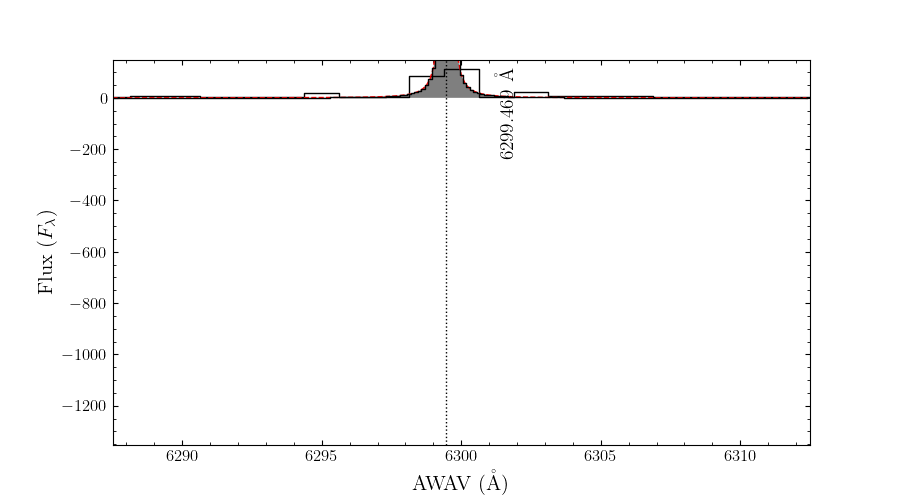

Peak 1 flux: 4.136e-17 erg / (cm2 s)


<Quantity [-33.93324865] km / s>

In [57]:
%matplotlib notebook
# oi6300.plot_contours()
# sky_cut1 = oi6300.spectral_profile(wave=oi6300.velwave.get_range(), arc=[22.4, 26], spec_unit=True, spat_unit=True)
# sky_cut2 = oi6300.spectral_profile(wave=oi6300.velwave.get_range(), arc=[-32, -30], spec_unit=True, spat_unit=True)

# sky_cut = (sky_cut1 + sky_cut2)
# sky_cut.data /= 2.
# sky_cut / 2.
# # help(oi6300.spectral_profile)
# sky_cut.data[sky_cut.data < 0] = median
# sky_cut.data[sky_cut.data < sky_cut.median()] = sky_cut.median()
# sky_cut.plot()

noise = np.std(get_noise1D(sky_cut.data.copy(), full=True))
weight = noise / np.ma.sqrt(abs(sky_cut.data))
sky_cut.fit_model(model_list=['l'], plot=True, weight=weight)

oi6300.radial_velocity(ref='OI6300', lbdas=6299.469, vcorr=vsys)

## Profiles & Fitting routines

We can also take a cut across a spatial or spectral pixel (or pixels) to look at linear profiles, using either `spatial_profile()` or `spectral_profile()` class methods. If we plot this, it is interactive so we can click on a point to save it as a coordinate. This can be passed to the fitter and a profile can be plotted as well. The fitter can be called separately with the `Modeller` class, or it can be called directly from the `SpecLine` or `SpatLine` instance. 

In cases where there are strong negative residuals, we can also mask values below some threshold to tidy up our plot and fit the data more reliably. For this, we will get the median and the background rms, and subtract an rms factor from the median to get a lower threshold.

In [5]:
from telassar.plotter import get_background_rms

median = oi6300.median()
sig = get_background_rms(oi6300.data, sigma=3)
thresh = median - (4.5 * sig)

oi6300.data[oi6300.data < thresh] = np.ma.masked

[INFO] Click on data points to save coordinates.


<IPython.core.display.Javascript object>


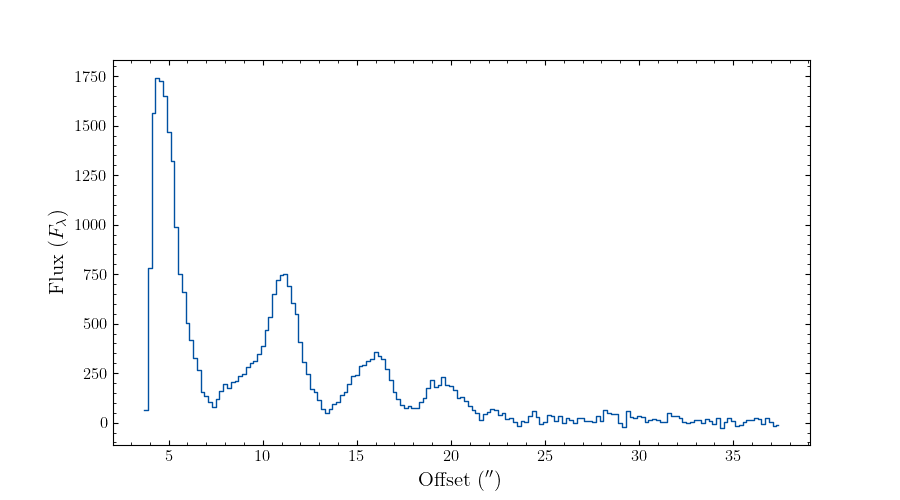

[INFO] SpatLine (no name)
[INFO] Data shape: (193) (arcsec, nounit)
[INFO] Spatial Offset: min: -1.0" max: 37.4" step: 0.200"
[INFO] No spectral coordinates installed


In [12]:
%matplotlib notebook

spatial_cut = oi6300.spatial_profile(
    arc=[-1., oi6300.position.get_stop()], 
    wave=[6302, 6306], 
    spat_unit=True, 
    spec_unit=True
)

spatial_cut.plot()

spatial_cut.info()

In this instance we have clicked 4 peaks (though one seems to be blended $\sim9^{\prime\prime}$, but we ignore it), and their `(offset, flux)` coordinates are stored in the `spatial_cut` instance. The fitter is designed to be able to fit multiple peaks, so we can pass the model names as single-character keys, i.e. `g` for a Gaussian model, `l` for a Lorentzian model, or `v` for a Voigt profile. These are all passed to `lmfit`. I haven't quite figured out how to really optimize it, so it is likely that the `model_list` will need to be tested and possibly run a few times to get it to work "correctly."

In [13]:
# model
coords = spatial_cut._coords

# coords[1] = (8.5, 196)
for offset, flux in coords:
    print("%0.4g \t %0.4g" % (offset, flux))
    


4.4 	 1743
8.4 	 205.1
11.2 	 752.1
16 	 357.6
19.8 	 190.7


<IPython.core.display.Javascript object>


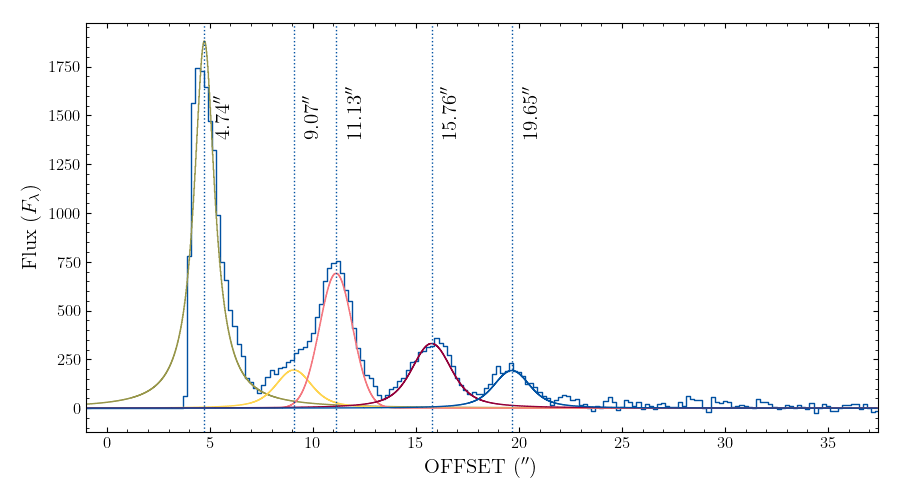

In [14]:
%matplotlib notebook
# from telassar.fitter import Modeller
# del model
model_list = ['l', 'v', 'g', 'v', 'v']
# model = Modeller(spatial_cut)
fitted_model = spatial_cut.fit_model(model_list, plot=True, weight=False)

In the next notebook we'll look at accessing the detailed fit statistics. For now, we are just interested in the profiles and fitting methods. For the moment, we can return an array of the basic fitted parameters with `model.get_info()`, which returns an `(Nx5)` array containing the flux, amplitude, fwhm, center, and sigma of the fits for `N` models. If `pandas` is installed we can specify an `as_dataframe` boolean keyword to return the values as a dataframe.

In [15]:
# this returns an array
fit_info = fitted_model.get_info()
print(fit_info)

# this is a dataframe
fit_dframe = fitted_model.get_info(as_dataframe=True)
fit_dframe

[[5.41918179e+03 3.57372616e+03 1.20990845e+00 4.73539830e+00
  6.04954226e-01]
 [7.87464700e+02 5.42859182e+02 2.08406925e+00 9.07139708e+00
  5.78700653e-01]
 [2.77160635e+03 1.38379353e+03 1.88160315e+00 1.11266427e+01
  7.99043303e-01]
 [1.61252018e+03 1.01077070e+03 2.29203240e+00 1.57619619e+01
  6.36447494e-01]
 [7.81498237e+02 5.36853850e+02 2.09141476e+00 1.96537265e+01
  5.80740343e-01]]


,flux,peak,fwhm,center,sigma
0,5419.181790,3573.726157,1.209908,4.735398,0.604954
1,787.464700,542.859182,2.084069,9.071397,0.578701
2,2771.606348,1383.793535,1.881603,11.126643,0.799043
3,1612.520182,1010.770699,2.292032,15.761962,0.636447
4,781.498237,536.853850,2.091415,19.653727,0.580740


This is a convenient way for us to calculate the radial velocity at each of the knots. 

[INFO] Click on data points to save coordinates.


<IPython.core.display.Javascript object>


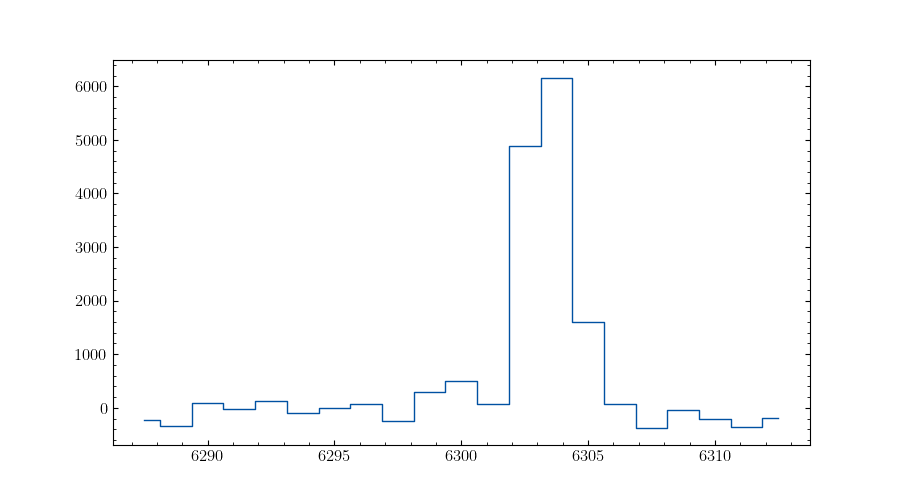

In [16]:
%matplotlib notebook

knot1 = oi6300.spectral_profile(
    wave=oi6300.velwave.get_range(),
    arc=[3.74, 5.74],
    spat_unit=True,
    spec_unit=True
)

knot1.plot()

Like before, we just click on the peak to store the coordinates, and then send it to the fitter.

<IPython.core.display.Javascript object>


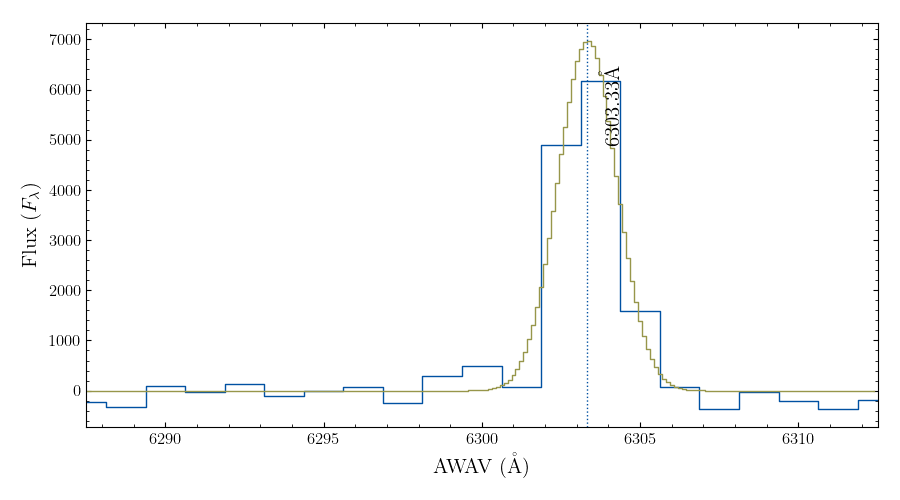

In [18]:
%matplotlib notebook
model = ['g']

knot1_fit = knot1.fit_model(model)

In [19]:
# what's the radial velocity?
velocity = oi6300.radial_velocity(ref='OI6300', lbdas=6303.33, vcorr=vsys)
print(velocity)

[149.79138973] km / s


I have not yet included passing different units here, but that's on my list.